In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/Tweets.csv
/kaggle/input/twitter-airline-sentiment/database.sqlite


# Importing relevant libraries and dataset

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split

import torch
from torch import functional as F

%matplotlib inline
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [141]:
ds = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv', parse_dates =['tweet_created'])
display(ds.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


# EDA

In [142]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype                                 
---  ------                        --------------  -----                                 
 0   tweet_id                      14640 non-null  int64                                 
 1   airline_sentiment             14640 non-null  object                                
 2   airline_sentiment_confidence  14640 non-null  float64                               
 3   negativereason                9178 non-null   object                                
 4   negativereason_confidence     10522 non-null  float64                               
 5   airline                       14640 non-null  object                                
 6   airline_sentiment_gold        40 non-null     object                                
 7   name                          14640 non-null  object                        

In [143]:
og_num_rows, og_num_feats = ds.shape[0], ds.shape[1]
og_num_rows, og_num_feats

(14640, 15)

There seem to be a substantial amount of missing data for certain columns, let's single them out.

In [144]:
# Extract the columns
columns_with_missing_values = ds.columns[ds.isna().sum() > 0]
columns_with_missing_values

Index(['negativereason', 'negativereason_confidence', 'airline_sentiment_gold',
       'negativereason_gold', 'tweet_coord', 'tweet_location',
       'user_timezone'],
      dtype='object')

In [145]:
na_values_sum = ds.isna().sum()[columns_with_missing_values]
na_values_sum

negativereason                5462
negativereason_confidence     4118
airline_sentiment_gold       14600
negativereason_gold          14608
tweet_coord                  13621
tweet_location                4733
user_timezone                 4820
dtype: int64

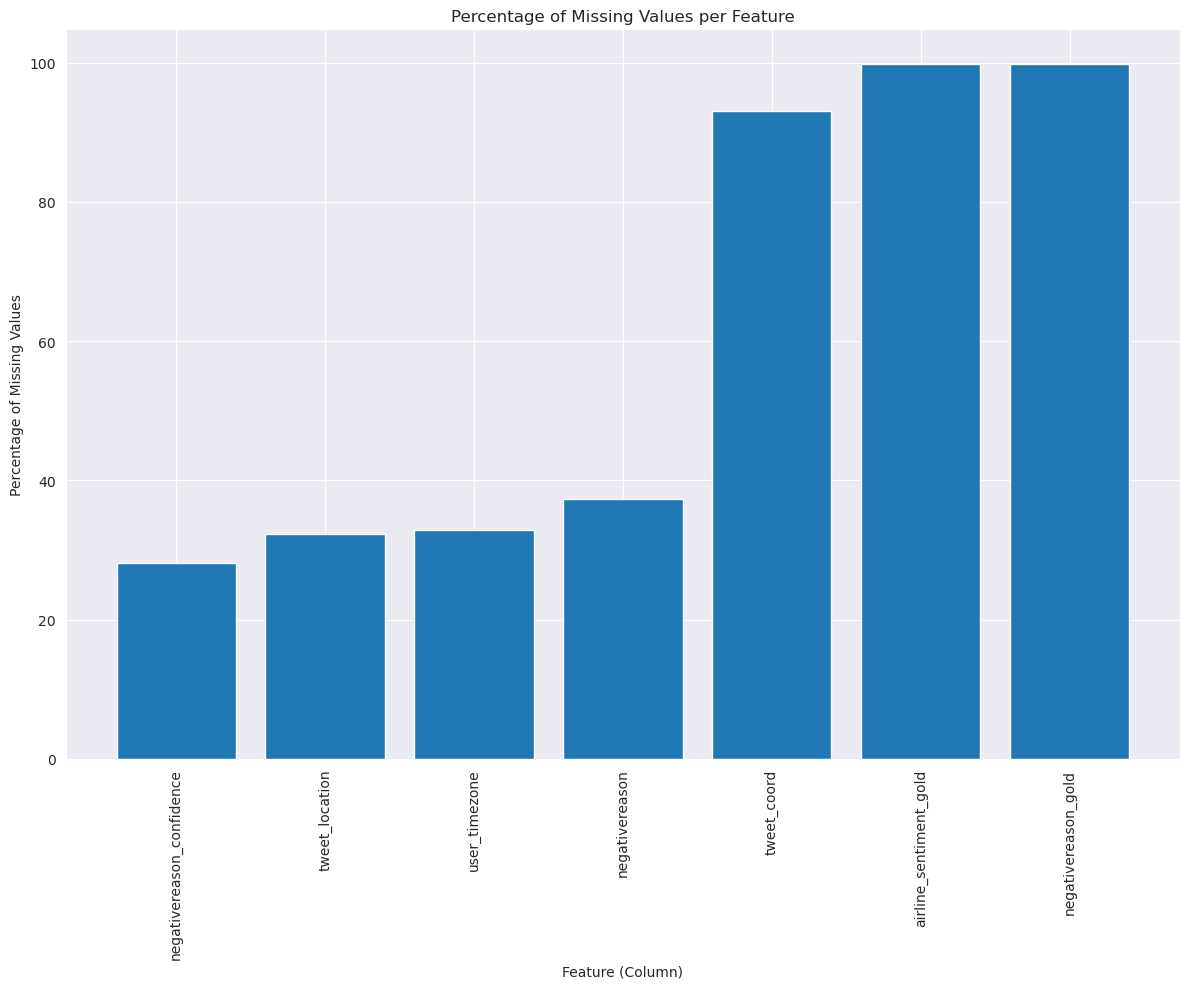

In [146]:
percentage_missing_values = (na_values_sum / og_num_rows) * 100
sorted_data = percentage_missing_values.sort_values(ascending = True)

# Plotting the graph
plt.figure(figsize=(12, 10))
plt.bar(sorted_data.index, sorted_data.values)
plt.xticks(rotation=90)
plt.xlabel('Feature (Column)')
plt.ylabel('Percentage of Missing Values')
plt.title('Percentage of Missing Values per Feature')
plt.tight_layout()
plt.show()

**In ascending order, we have:**  
>'negativereason_confidence' < 'tweet_location' < 'user_timezone' < 'negativereason' < 'tweet_coord' < 'airline_sentiment_gold' < 'negativereason_gold'  
It appears that the proportions of missing values in:
**tweet_coord' < 'airline_sentiment_gold' < 'negativereason_gold' are way too high.**  
Let's opt to remove it.

In [153]:
ds.drop(['negativereason_gold', 'airline_sentiment_gold', 'tweet_coord'], axis = 1, inplace = True)
columns_with_missing_values = columns_with_missing_values.drop(['negativereason_gold', 'airline_sentiment_gold', 'tweet_coord'])

In [154]:
display(ds.head())

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)


In [172]:
ds.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
name                             7701
retweet_count                      18
text                            14427
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [173]:
# remove features with high cardinality if not numerical
irrelevant_cols = ['tweet_id', 'name']
ds.drop(irrelevant_cols, axis = 1, inplace = True)

In [174]:
new_num_rows, new_num_feats = ds.shape[0], ds.shape[1]
new_num_rows, new_num_feats

(14640, 10)

Let's review again, our missing columns.

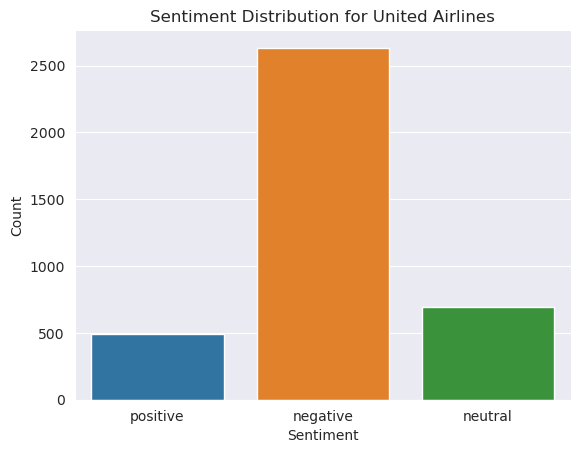

In [157]:
new_ds = ds[ds['airline'] == 'United']
count = new_ds['airline_sentiment'].value_counts()

# Plotting the count plot
sns.countplot(x='airline_sentiment', data=new_ds)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution for United Airlines')
plt.show()

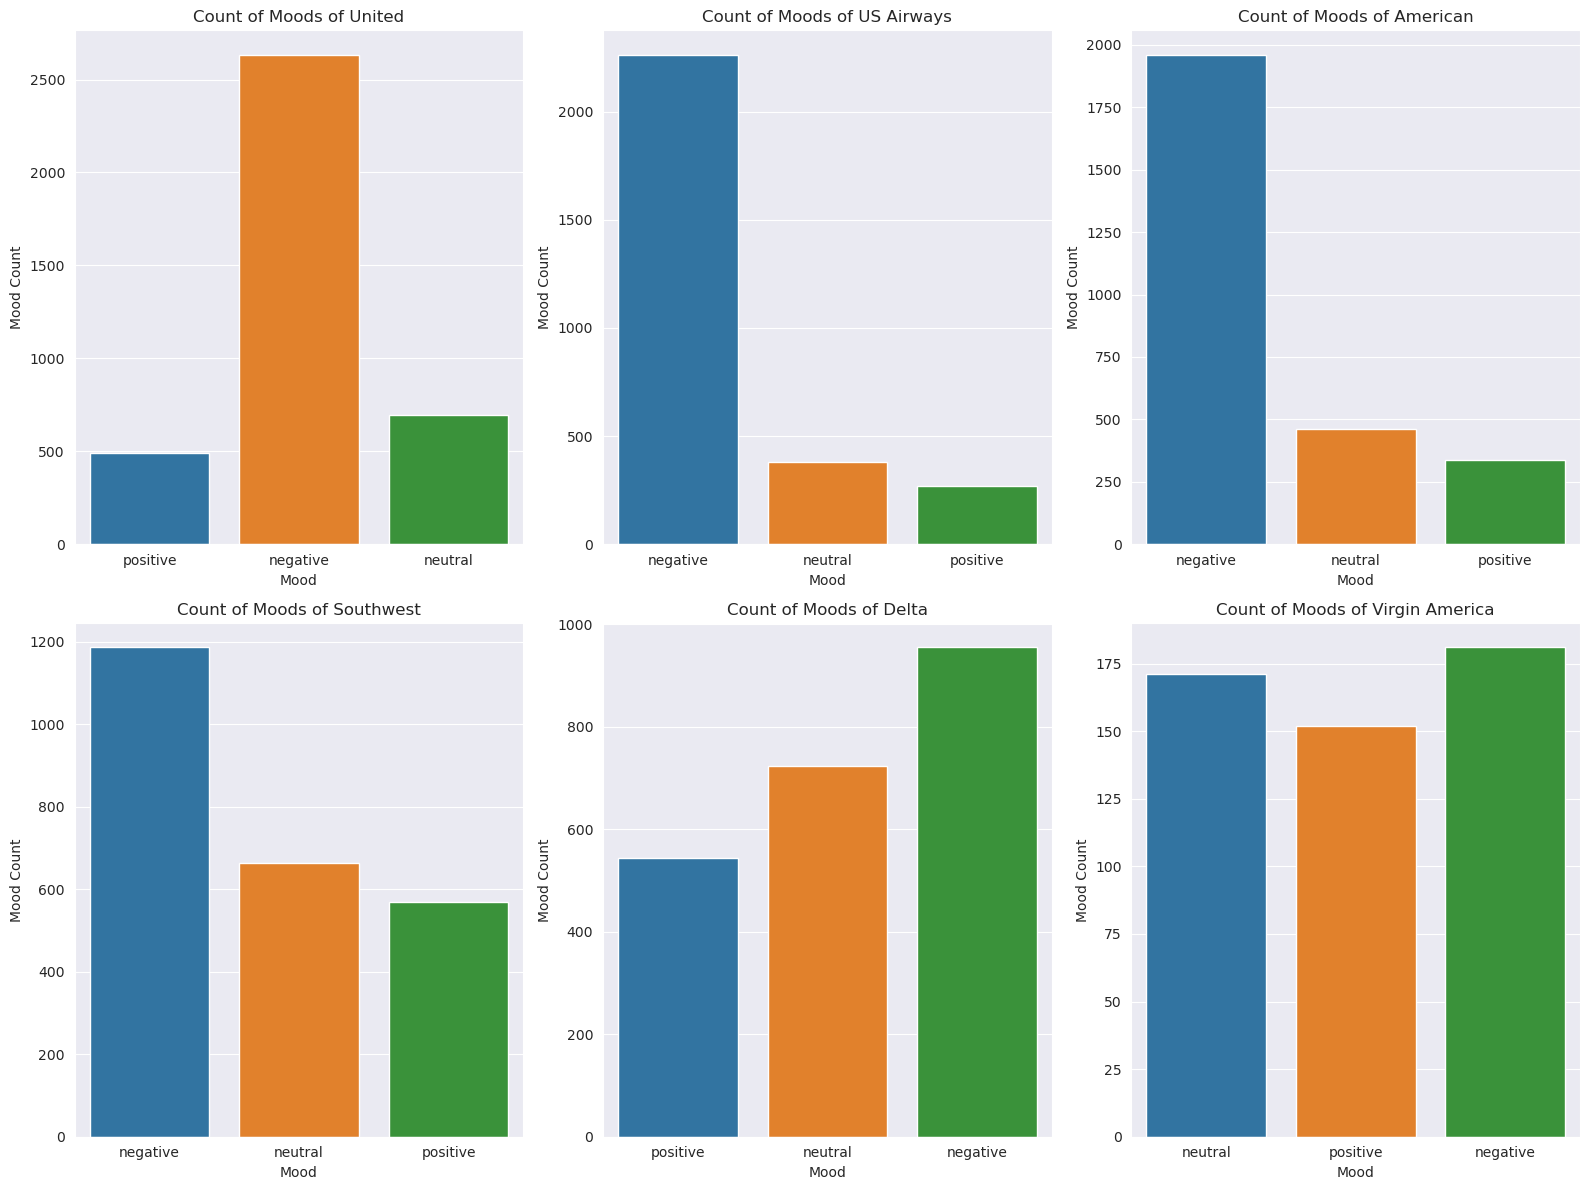

In [101]:
airlines= list(ds['airline'].value_counts().index)
plt.figure(1,figsize=(16, 12))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2,3,indices + 1)
    new_ds=ds[ds['airline'] == i]
    count=new_ds['airline_sentiment'].value_counts()
    sns.countplot(data = new_ds, x = 'airline_sentiment')
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+ i)
plt.tight_layout()

In [110]:
total_tweets

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: airline_sentiment, dtype: int64

In [114]:
my_dict = {'American':neg_tweets['American']['negative'] / total_tweets['American'],'Delta':neg_tweets['Delta']['negative'] / total_tweets['Delta'],'Southwest': neg_tweets['Southwest']['negative'] / total_tweets['Southwest'],
'US Airways': neg_tweets['US Airways']['negative'] / total_tweets['US Airways'],'United': neg_tweets['United']['negative'] / total_tweets['United'],'Virgin': neg_tweets['Virgin America']['negative'] / total_tweets['Virgin America']}
perc = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc

,0
American,0.710402
Delta,0.429793
Southwest,0.490083
US Airways,0.776862
United,0.688906
Virgin,0.359127


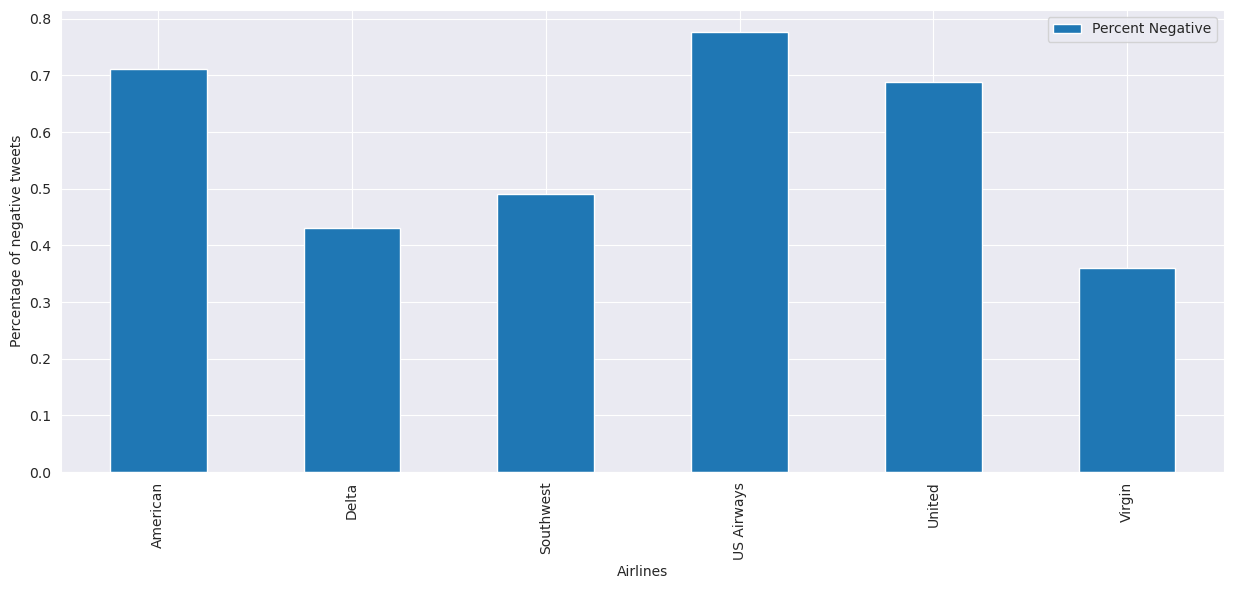

In [126]:
neg_tweets = ds.groupby(['airline','airline_sentiment']).count().iloc[:,0]
total_tweets = ds.groupby(['airline'])['airline_sentiment'].count()

my_dict = {'American':neg_tweets['American']['negative'] / total_tweets['American'],'Delta':neg_tweets['Delta']['negative'] / total_tweets['Delta'],'Southwest': neg_tweets['Southwest']['negative'] / total_tweets['Southwest'],
'US Airways': neg_tweets['US Airways']['negative'] / total_tweets['US Airways'],'United': neg_tweets['United']['negative'] / total_tweets['United'],'Virgin': neg_tweets['Virgin America']['negative'] / total_tweets['Virgin America']}
perc_neg = pd.DataFrame.from_dict(my_dict, orient = 'index')
perc_neg.columns = ['Percent Negative']
ax = perc_neg.plot(kind = 'bar', figsize = (15,6))
ax.set_xlabel('Airlines')
ax.set_ylabel('Percentage of negative tweets')
plt.show()

* United, US Airways, American substantially get more negative reactions.
* Tweets for Virgin America are the most positive.

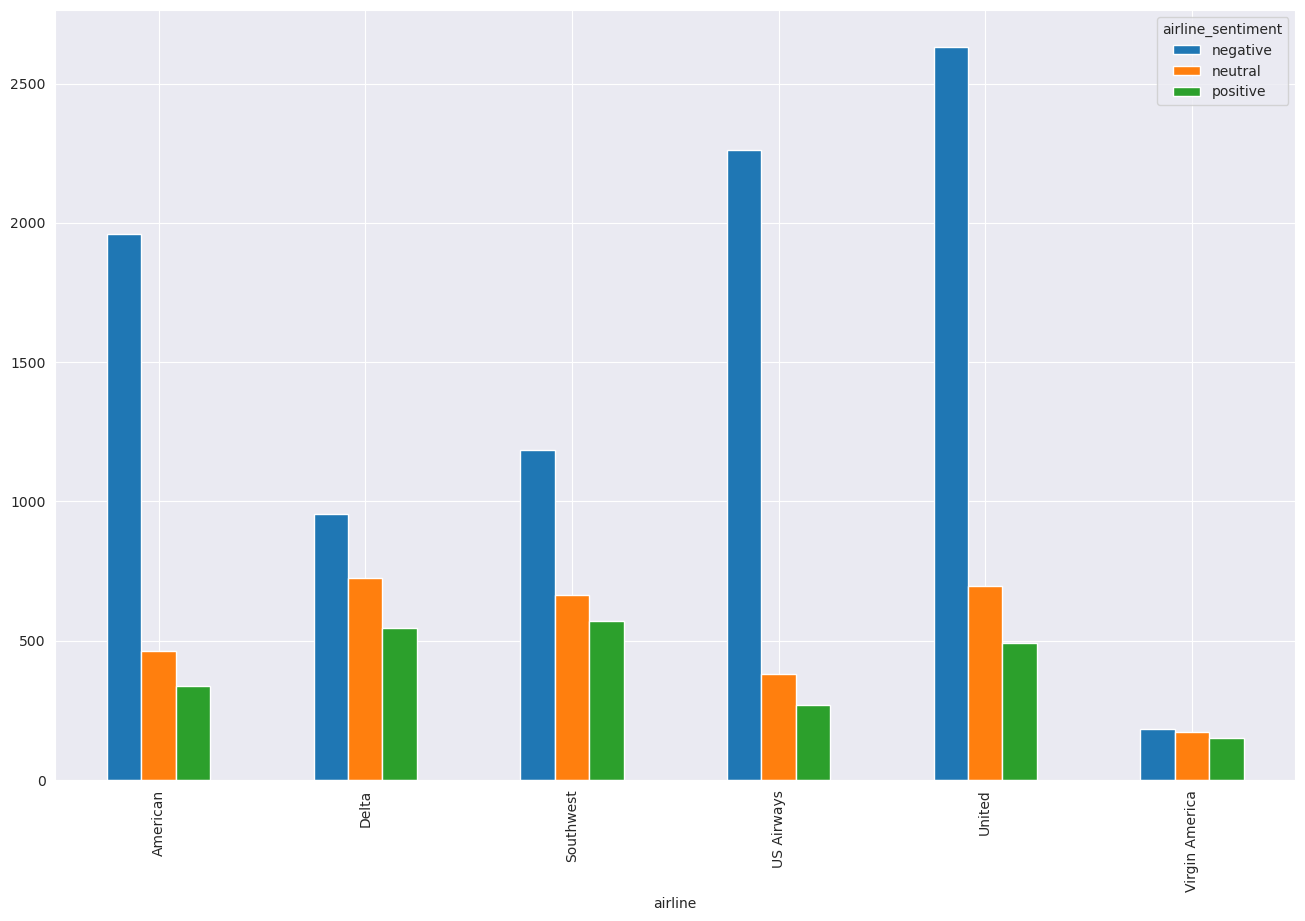

In [135]:
figure_2 = ds.groupby(['airline', 'airline_sentiment']).size()
figure_2.unstack().plot(kind='bar', figsize=(16,10))
plt.axis(True)
plt.show()

* Virgin America is indeed the most balanced.

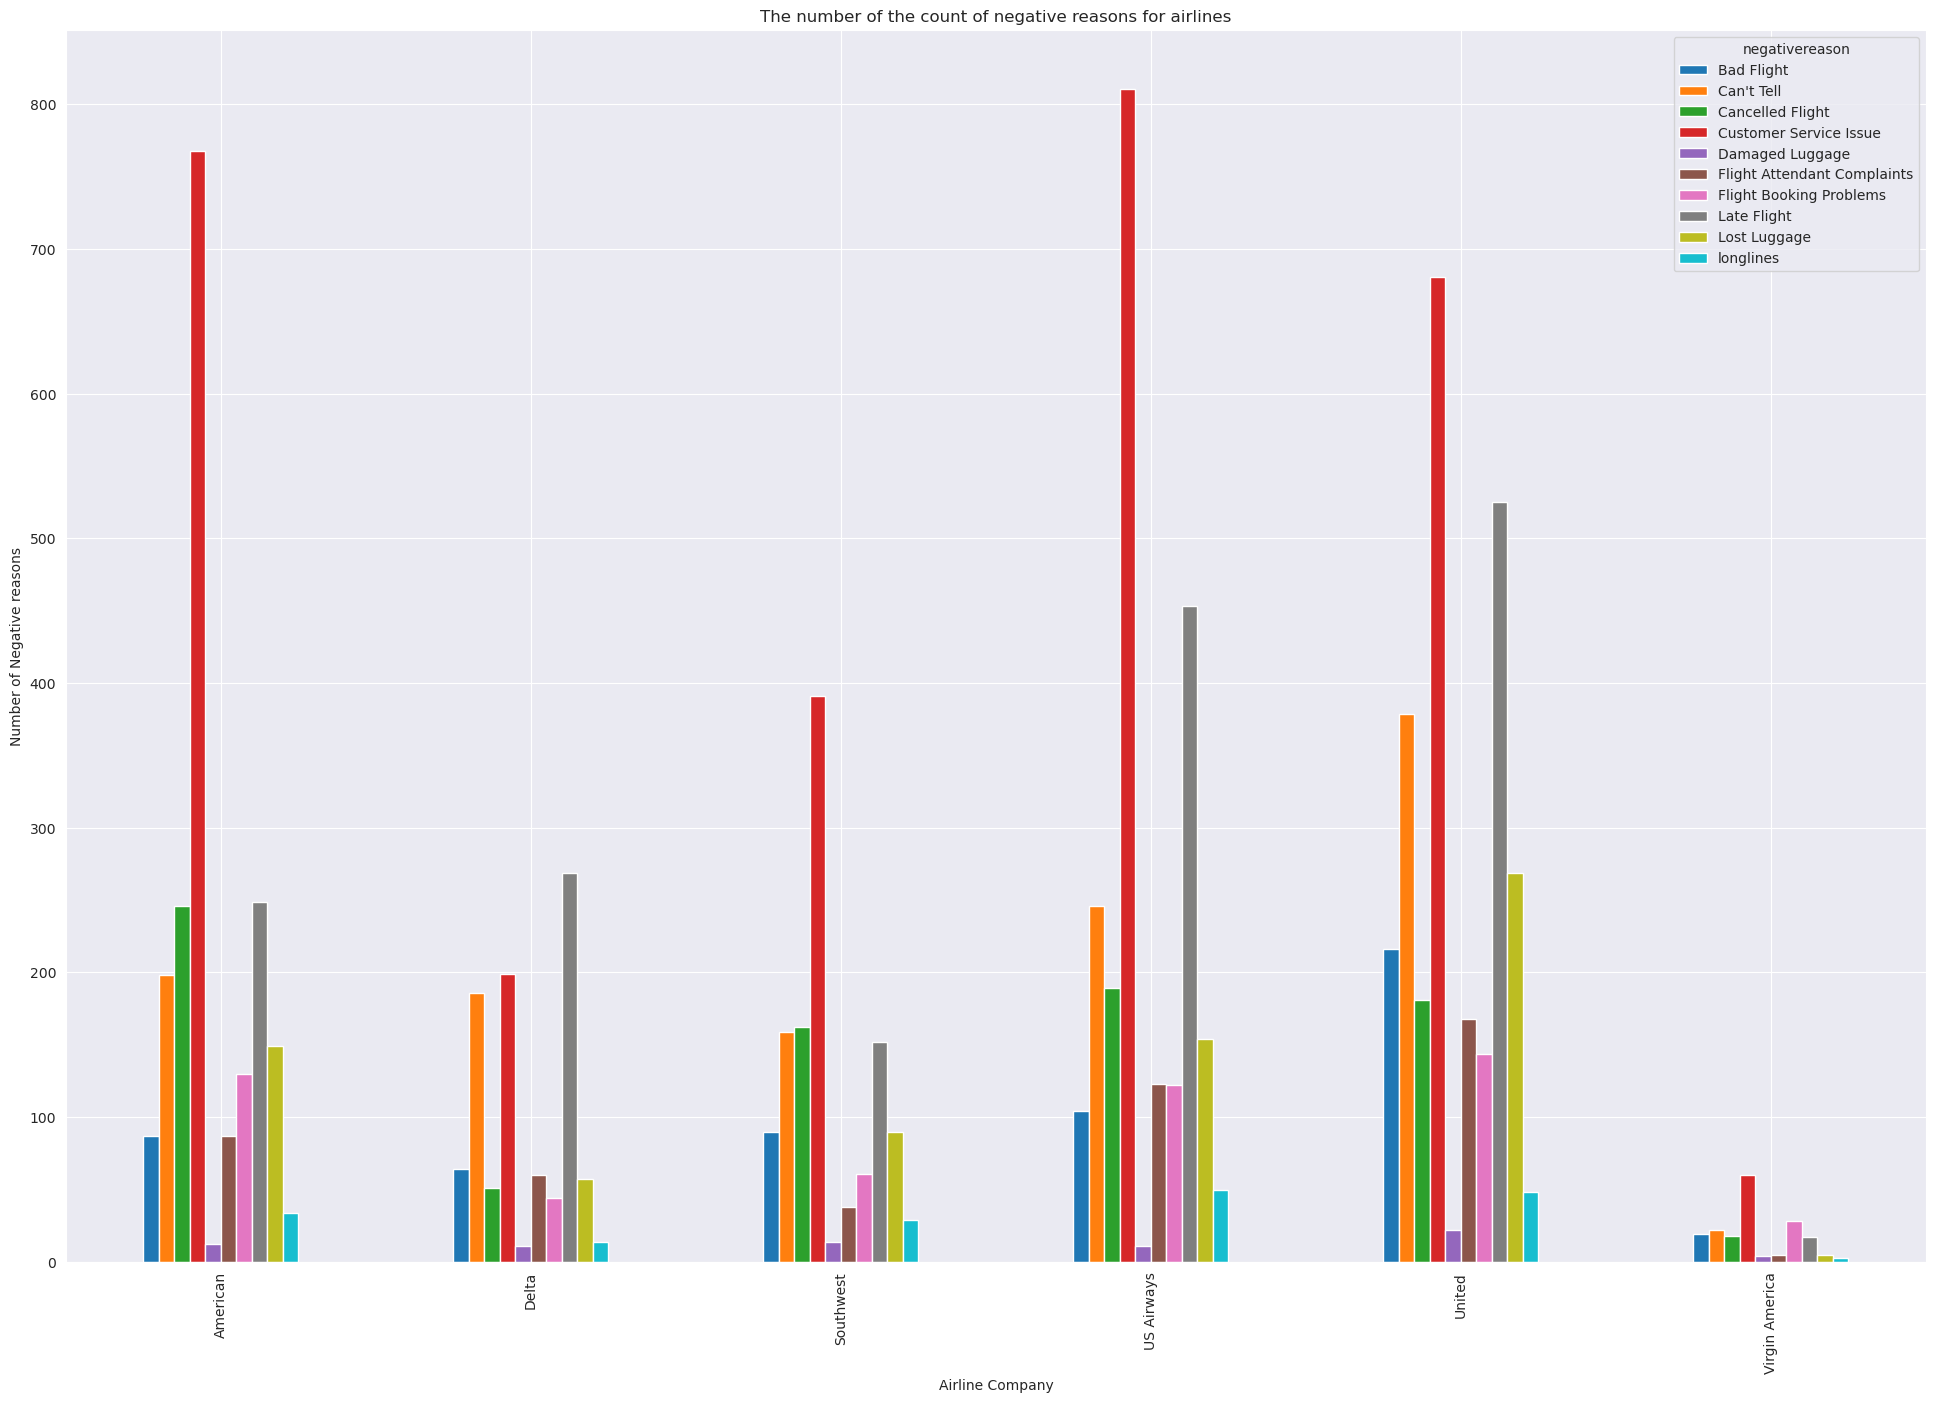

In [137]:
negative_reasons = ds.groupby('airline')['negativereason'].value_counts(ascending=True)
negative_reasons.groupby(['airline','negativereason']).sum().unstack().plot(kind='bar',figsize=(24,16))
plt.xlabel('Airline Company')
plt.ylabel('Number of Negative reasons')
plt.title("The number of the count of negative reasons for airlines")
plt.show()

* It appears Customer Service is of utmost importance to customers as it is consistently listed as the top reason across most of the airlines.

# Cleaning the data

In [188]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['airline_sentiment', 'negativereason', 'airline']),
    ('passthrough', 'passthrough', ['airline_sentiment_confidence', 'negativereason_confidence', 'retweet_count'])
])

new_ds = transformer.fit_transform(ds)

In [192]:
from sklearn.impute import KNNImputer

# Create the KNNImputer instance
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the data
new_ds_filled = imputer.fit_transform(new_ds)
new_ds_filled

array([[0.    , 1.    , 0.    , ..., 1.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.3486, 0.    , 0.    ],
       [0.    , 1.    , 0.    , ..., 0.6837, 0.    , 0.    ],
       ...,
       [0.    , 1.    , 0.    , ..., 1.    , 0.    , 0.    ],
       [1.    , 0.    , 0.    , ..., 1.    , 0.6659, 0.    ],
       [0.    , 1.    , 0.    , ..., 0.6771, 0.    , 0.    ]])

In [197]:
new_df_filled = pd.DataFrame(new_ds_filled, columns= transformer.get_feature_names_out())
new_df_filled.drop(['ohe__airline_sentiment_negative','ohe__airline_sentiment_neutral','ohe__airline_sentiment_positive'], inplace = True, axis = 1)

In [216]:
ds.columns

Index(['airline_sentiment', 'airline_sentiment_confidence', 'negativereason',
       'negativereason_confidence', 'airline', 'retweet_count', 'text',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

In [219]:
ds

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,retweet_count,text,tweet_created,tweet_location,user_timezone
0,neutral,1.0000,NaN,NaN,Virgin America,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52-08:00,NaN,Eastern Time (US & Canada)
1,positive,0.3486,NaN,0.0000,Virgin America,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59-08:00,NaN,Pacific Time (US & Canada)
2,neutral,0.6837,NaN,NaN,Virgin America,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48-08:00,Lets Play,Central Time (US & Canada)
3,negative,1.0000,Bad Flight,0.7033,Virgin America,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36-08:00,NaN,Pacific Time (US & Canada)
4,negative,1.0000,Can't Tell,1.0000,Virgin America,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45-08:00,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...
14635,positive,0.3487,NaN,0.0000,American,0,@AmericanAir thank you we got on a different f...,2015-02-22 12:01:01-08:00,NaN,NaN
14636,negative,1.0000,Customer Service Issue,1.0000,American,0,@AmericanAir leaving over 20 minutes Late Flig...,2015-02-22 11:59:46-08:00,Texas,NaN
14637,neutral,1.0000,NaN,NaN,American,0,@AmericanAir Please bring American Airlines to...,2015-02-22 11:59:15-08:00,"Nigeria,lagos",NaN
14638,negative,1.0000,Customer Service Issue,0.6659,American,0,"@AmericanAir you have my money, you change my ...",2015-02-22 11:59:02-08:00,New Jersey,Eastern Time (US & Canada)


In [235]:
new_ds = new_df_filled.join(ds[['text', 'tweet_created', 'tweet_location', 'user_timezone']])
new_ds.fillna('None', inplace = True)
target = ds['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [230]:
import string

In [237]:
def clean_text(df):
    df['cleaned_text'] = df['text'].apply(lambda x: x.lower())
    df['cleaned_text'] = df['cleaned_text'].apply(lambda x: x.translate(str.maketrans('','', string.punctuation)))

clean_text(new_ds)
X = new_ds['cleaned_text']
y = target

In [266]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words = stopwords.words('english'))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [272]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

models = [BernoulliNB(), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier(), SVC(), XGBClassifier()]
results = {}
for model in models:
    model.fit(X_train_vec, y_train)
    preds = model.predict(X_test_vec)
    acc = accuracy_score(y_test, preds)
    
    model_name = model.__class__.__name__
    results[model_name] = {}
    results[model_name]['accuracy'] = acc

In [285]:
results

{'BernoulliNB': {'accuracy': 0.7414617486338798},
 'MultinomialNB': {'accuracy': 0.6953551912568307},
 'RandomForestClassifier': {'accuracy': 0.7728825136612022},
 'KNeighborsClassifier': {'accuracy': 0.7114071038251366},
 'SVC': {'accuracy': 0.792691256830601},
 'XGBClassifier': {'accuracy': 0.7694672131147541}}

In [276]:
pd.DataFrame(results).T.sort_values(by = ['accuracy'], ascending = False)

,accuracy
SVC,0.79
RandomForestClassifier,0.77
XGBClassifier,0.77
BernoulliNB,0.74
KNeighborsClassifier,0.71
MultinomialNB,0.70


* SVC perfomed the best out of all the models, let's run gridsearch for the top 3 performing models.

In [279]:
from sklearn.model_selection import GridSearchCV

models = {
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'XGBClassifier': XGBClassifier()
}

grid = {
    'SVC': 
    {
        'C': [1, 10, 100], 
        'kernel': ['linear', 'rbf'],
    },
    'RandomForestClassifier': 
    {
        'n_estimators': [None, 10, 50],
        'max_depth': [3, 10, 20],
    },
    'XGBClassifier': 
    {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
    }
}

for model_name, model in models.items():
    model_to_fit = GridSearchCV(estimator=model, param_grid=grid[model_name], cv=3)
    model_to_fit.fit(X_train_vec, y_train)

    # print the best parameters for each model
    print(f'Best parameters for {model_name}: {model_to_fit.best_params_}')


Best parameters for SVC: {'C': 1, 'kernel': 'linear'}
Best parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 10}
Best parameters for XGBClassifier: {'learning_rate': 0.2, 'n_estimators': 150}


* Let's use VotingClassifier to generate an emsembled model.

In [283]:
from sklearn.ensemble import VotingClassifier

svc = SVC(C = 1, kernel =  'linear', probability = True)
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 10)
xgbc = XGBClassifier(learning_rate = 0.2, n_estimators = 150)

voting_clf = VotingClassifier(
    estimators=[('svc', svc), ('rf', rfc), ('xgb', xgbc)],
    voting='soft'
)

# Fit and predict
voting_clf.fit(X_train_vec, y_train)
y_pred = voting_clf.predict(X_test_vec)

In [284]:
accuracy_score(y_test, y_pred)

0.7930327868852459

In [286]:
from sklearn.model_selection import cross_val_score
cross_val_score(voting_clf, X_train_vec, y_train, cv = 5, verbose = 1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min finished


array([0.77166026, 0.76952625, 0.77156277, 0.7707088 , 0.76387703])

In [287]:
from sklearn.ensemble import StackingClassifier

base_models = [
    ('rf', RandomForestClassifier(max_depth = 20, n_estimators = 10)),
    ('svc', SVC(C = 1, kernel =  'linear')),
    ('xgb', XGBClassifier(learning_rate = 0.2, n_estimators = 150))
]

meta_model = XGBClassifier()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the stacking classifier to the training data
stacking_clf.fit(X_train_vec, y_train)

# Use the stacking classifier to make predictions
y_pred = stacking_clf.predict(X_test_vec)
accuracy_score(y_test, y_pred)

0.7950819672131147

In [288]:
# Just for the sake of experimentation
base_models = [
    ('rf', RandomForestClassifier(max_depth = 20, n_estimators = 10)),
    ('svc', SVC(C = 1, kernel =  'linear')),
    ('vc', voting_clf)
]

meta_model = XGBClassifier()

stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Fit the stacking classifier to the training data
stacking_clf.fit(X_train_vec, y_train)

# Use the stacking classifier to make predictions
y_pred = stacking_clf.predict(X_test_vec)
accuracy_score(y_test, y_pred)

0.787568306010929

# ###TBD PyTorch###